**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**SUPERVISED MACHINE LEARNING: MODELAGEM MULTINÍVEL**<br>
**Prof. Dr. Luiz Paulo Fávero**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>


*coding: utf-8*

In [1]:
# In[0.1]: Instalação dos pacotes

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests
# !pip install -q pymer4

In [2]:
# In[0.2]: Importação dos pacotes necessários

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import matplotlib.image as mpimg # carregar imagem 
import statsmodels.api as sm # estimação de modelos
from pymer4.models import Lmer # estimação de modelos HLM3 neste código
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statstests.process import stepwise
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código

import warnings 
warnings.filterwarnings('ignore')

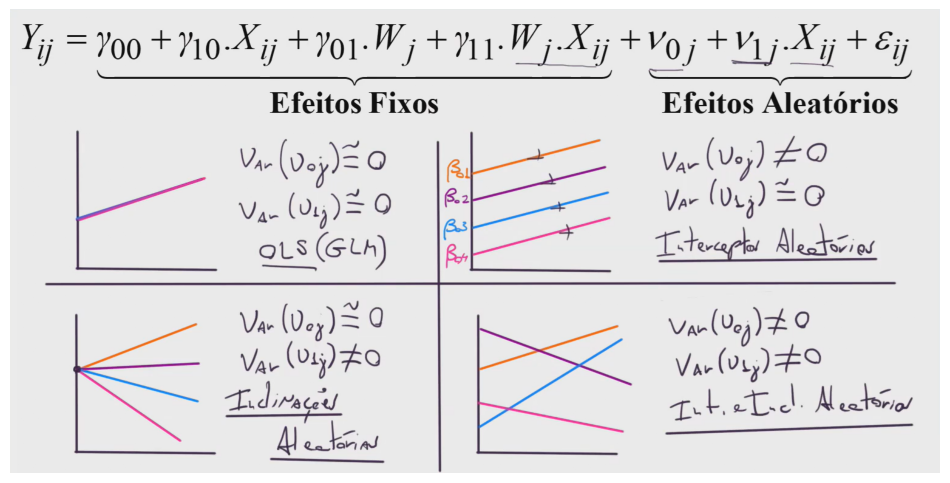

In [3]:
# Complementar
# Carregar a imagem
img = mpimg.imread('images/output_conceito.png')

# Exibir a imagem
plt.figure(figsize=(12,9))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

In [4]:
# In[HLM2]:
##############################################################################
##############################################################################
#                ESTIMAÇÃO DE MODELOS HIERÁRQUICOS LINEARES                  #
#                    DE DOIS NÍVEIS COM DADOS AGRUPADOS                      #
##############################################################################
##############################################################################

##############################################################################
#        DESCRIÇÃO E EXPLORAÇÃO DO DATASET 'desempenho_aluno_escola'         #
##############################################################################

# Carregamento da base de dados 'desempenho_aluno_escola'
df_aluno_escola = pd.read_csv('data/desempenho_aluno_escola.csv', delimiter=',')

# Visualização da base de dados 'desempenho_aluno_escola'
df_aluno_escola.head()

,estudante,escola,desempenho,horas,texp
0,1,1,25.0,11,3.6
1,2,1,52.0,23,3.6
2,3,1,52.0,25,3.6
3,4,1,30.0,14,3.6
4,5,1,51.0,24,3.6


In [5]:
# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df_aluno_escola['estudante'] = df_aluno_escola['estudante'].astype('category')
df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('category')

# Características das variáveis do dataset
df_aluno_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   estudante   358 non-null    category
 1   escola      358 non-null    category
 2   desempenho  358 non-null    float64 
 3   horas       358 non-null    int64   
 4   texp        358 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 20.8 KB


In [6]:
# Estatísticas univariadas
df_aluno_escola.describe()

,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


In [7]:
# In[1.1]: Estudo sobre o desbalanceamento dos dados por escola

df_aluno_escola.groupby('escola')['estudante'].count().reset_index()

,escola,estudante
0,1,47
1,2,25
2,3,48
3,4,20
4,5,48
5,6,30
6,7,28
7,8,35
8,9,44
9,10,33


In [8]:
# In[1.2]: Desempenho médio dos estudantes por escola

desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()
desempenho_medio

,escola,desempenho
0,1,36.765957
1,2,21.400000
2,3,67.125000
3,4,55.325000
4,5,19.270833
5,6,33.966667
6,7,57.532143
7,8,75.428571
8,9,18.556818
9,10,38.590909


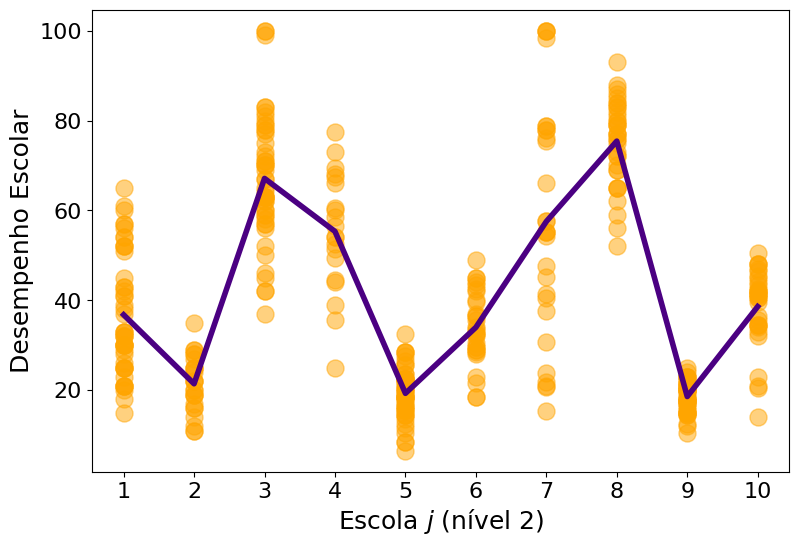

In [9]:
# In[1.3]: Gráfico do desempenho escolar médio dos estudantes por escola

plt.figure(figsize=(9,6))
plt.plot(desempenho_medio['escola'], desempenho_medio['desempenho'],
         linewidth=4, color='indigo')
plt.scatter(df_aluno_escola['escola'], df_aluno_escola['desempenho'],
            alpha=0.5, color='orange', s = 150)
plt.xlabel('Escola $j$ (nível 2)', fontsize=18)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.xticks(desempenho_medio.escola, fontsize=16)
plt.yticks(fontsize=16)
plt.show()

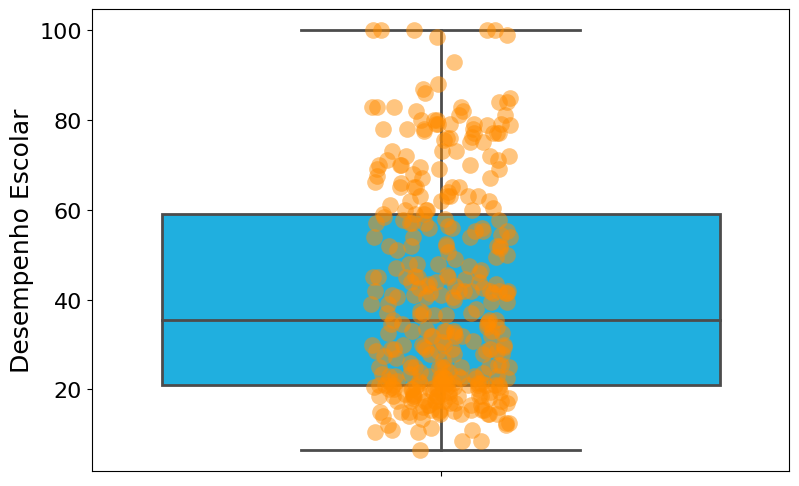

In [10]:
# In[1.4]: Boxplot da variável dependente ('desempenho')

plt.figure(figsize=(9,6))
sns.boxplot(data=df_aluno_escola, y='desempenho',
            linewidth=2, orient='v', color='deepskyblue')
sns.stripplot(data=df_aluno_escola, y='desempenho',
              color='darkorange', jitter=0.1, size=12, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.yticks(fontsize=16)
plt.show()

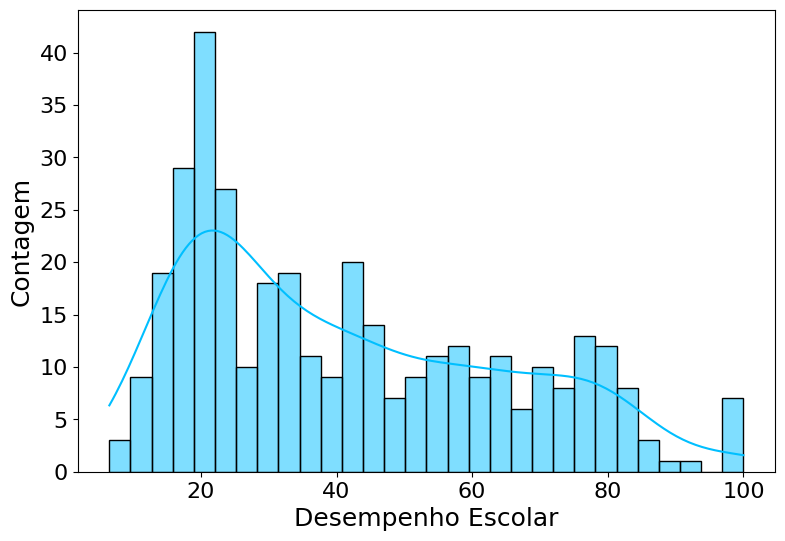

In [11]:
# In[1.5]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma

plt.figure(figsize=(9,6))
sns.histplot(data=df_aluno_escola['desempenho'], kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho Escolar', fontsize=18)
plt.ylabel('Contagem', fontsize=18)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.show()

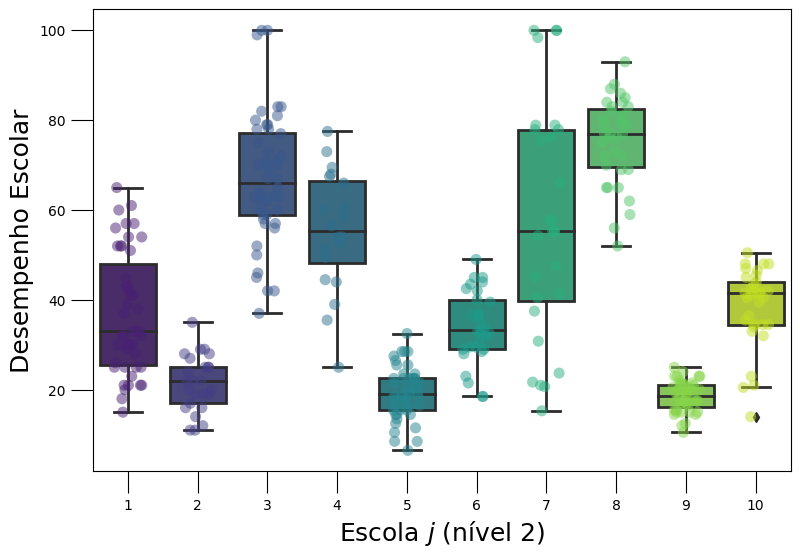

In [12]:
# In[1.6]: Boxplot da variável dependente ('desempenho') por escola

plt.figure(figsize=(9,6))
sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',
            linewidth=2, orient='v', palette='viridis')
sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',
              palette='viridis', jitter=0.2, size=8, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.xlabel('Escola $j$ (nível 2)', fontsize=18)
plt.tick_params(axis='y', size=16)
plt.tick_params(axis='x', size=16)
plt.show()

<Figure size 900x600 with 0 Axes>

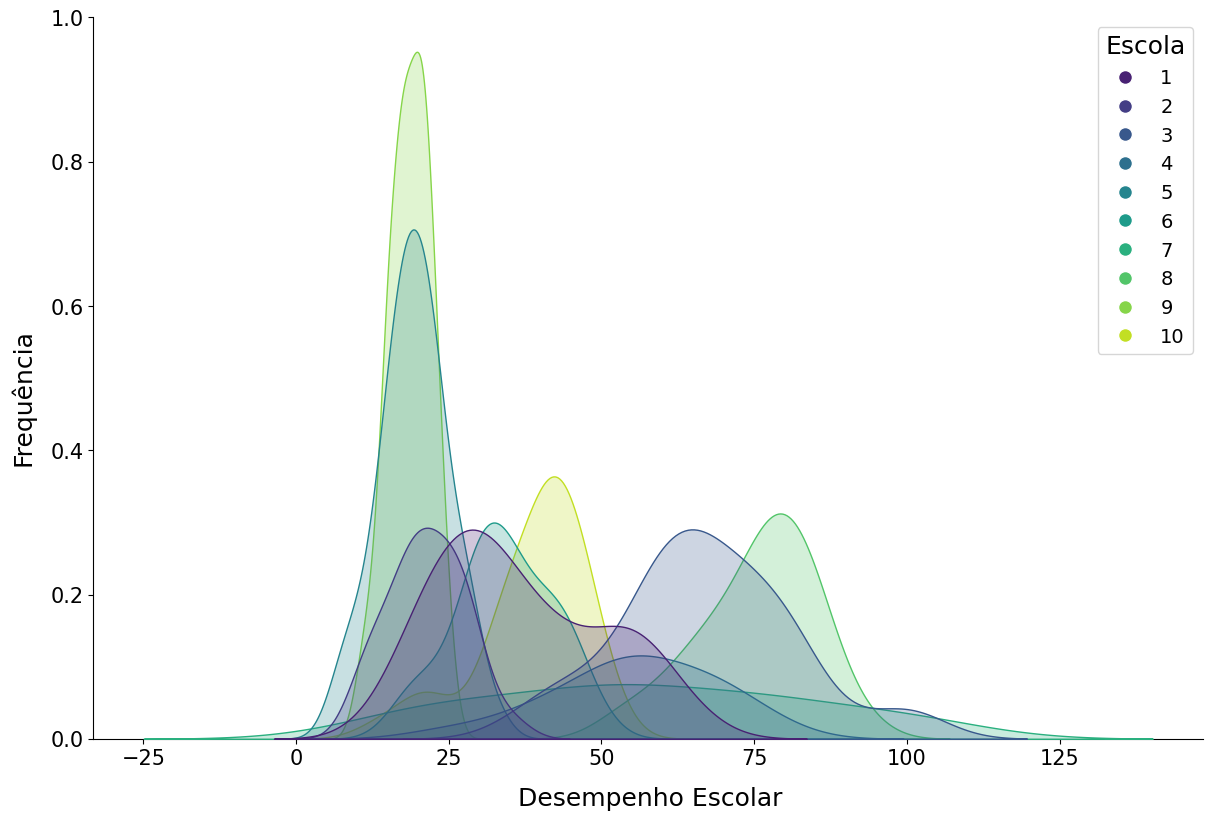

In [13]:
# In[1.7]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho') por escola

escolas = df_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

plt.figure(figsize=(9,6))
g = sns.pairplot(df_aluno_escola[['escola', 'desempenho']], hue='escola',
                 height=8,
                 aspect=1.5, palette=colors)
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
g.tick_params(axis='both', which='major', labelsize=15)

# Gera a legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color,
                              markersize=10, label=escola)
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14,
           title_fontsize=18)

# Adiciona os rótulos diretamente na figura
plt.gcf().text(0.5, -0.01, 'Desempenho Escolar', ha='center', fontsize=18)
plt.gcf().text(-0.01, 0.5, 'Frequência', va='center', rotation='vertical',
               fontsize=18)
plt.show()

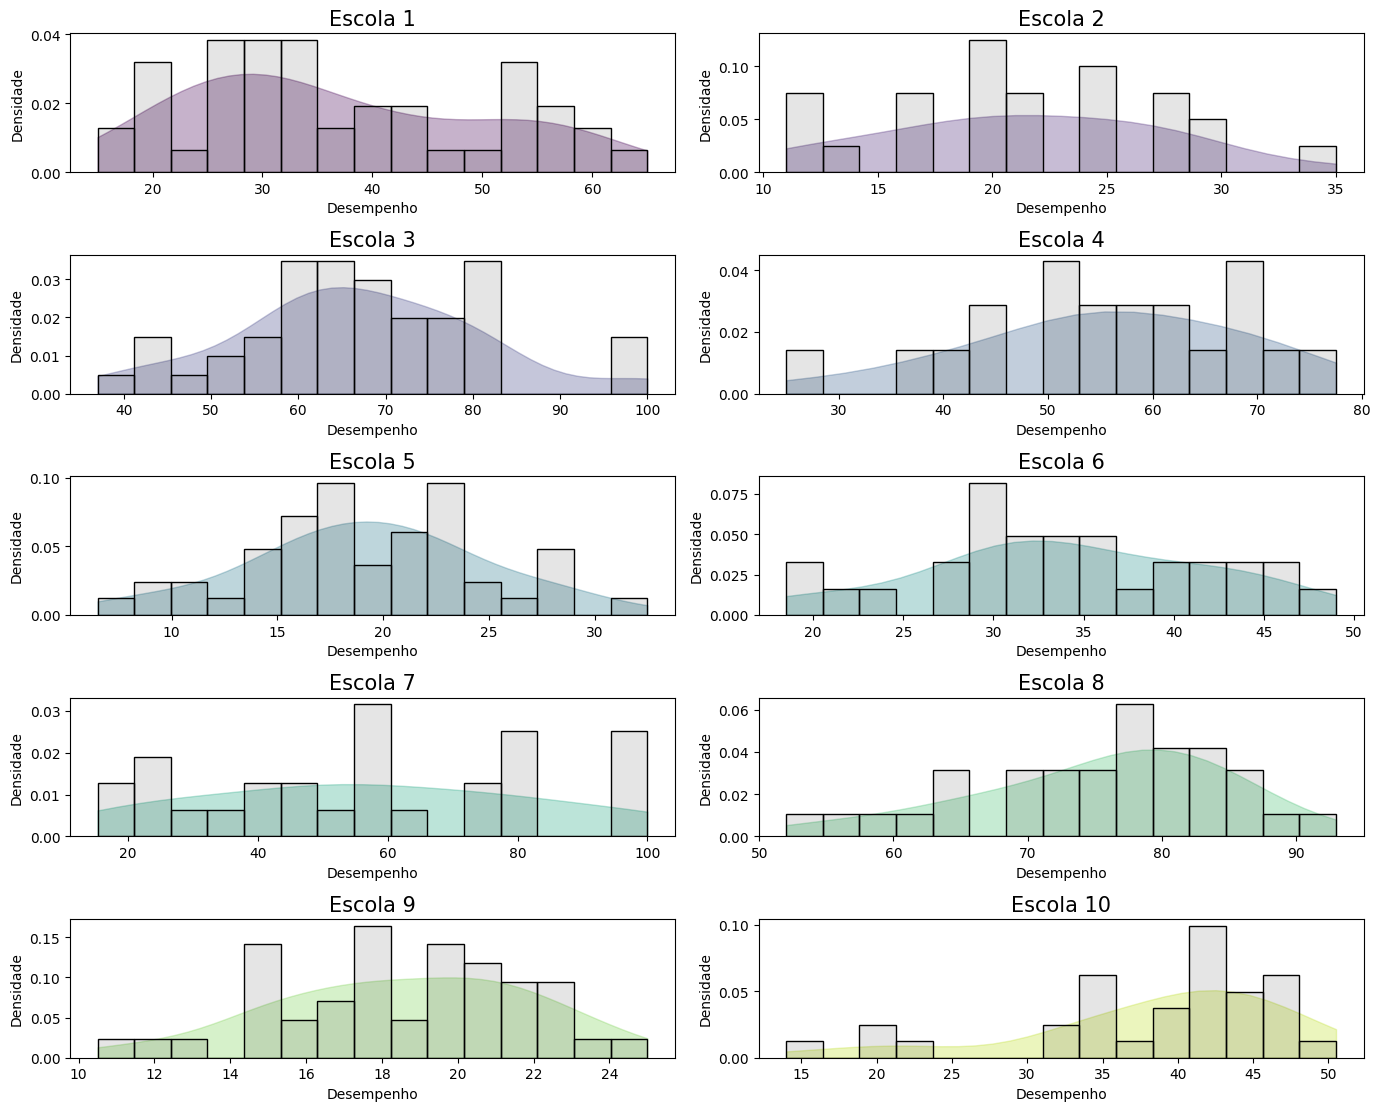

In [14]:
# In[1.8]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma e por escola separadamente
#(função 'GridSpec' do pacote 'matplotlib.gridspec')

escolas = df_aluno_escola['escola'].unique()

fig = plt.figure(figsize=(14, 13))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

for i, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[i])

    # Subset dos dados por escola
    df_escola = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Densidade dos dados
    densidade = gaussian_kde(df_escola['desempenho'])
    x_vals = np.linspace(min(df_escola['desempenho']),
                         max(df_escola['desempenho']), len(df_escola))
    y_vals = densidade(x_vals)

    # Plotagem da density area
    ax.fill_between(x_vals, y_vals,
                    color=sns.color_palette('viridis',
                                            as_cmap=True)(i/len(escolas)),
                    alpha=0.3)
    
    # Adiciona o histograma
    sns.histplot(df_escola['desempenho'], ax=ax, stat="density", color="black",
                 edgecolor="black", fill=True, 
                 bins=15, alpha=0.1)
    ax.set_title(f'Escola {escola}', fontsize=15)
    ax.set_ylabel('Densidade')
    ax.set_xlabel('Desempenho')

plt.tight_layout()
plt.show()

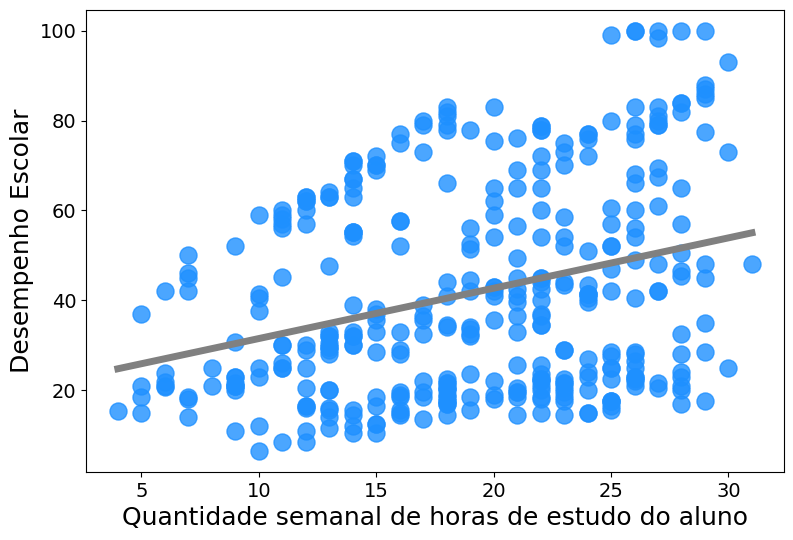

In [15]:
# In[1.9]: Gráfico de desempenho x horas (OLS)

plt.figure(figsize=(9,6))
sns.regplot(data=df_aluno_escola, x='horas', y='desempenho', marker='o', ci=False,
            scatter_kws={"color":'dodgerblue', 'alpha':0.8, 's':150},
            line_kws={"color":'grey', 'linewidth': 5})
plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=18)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [16]:
# # In[1.10]: Gráfico de desempenho x horas (OLS) por escola separadamente
# # Animação no ambiente Plots

# # Obtenção da lista de escolas
# escolas = df_aluno_escola['escola'].unique()

# # Definição do número de cores na paleta viridis
# num_cores = len(escolas)

# # Criação do dicionário de mapeamento da escola -> cor
# cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# while True:
#     # Loop para cada escola
#     for escola in escolas:
#         # Filtro dos dados para determinada escola
#         data = df_aluno_escola[df_aluno_escola['escola'] == escola]

#         # Criação do lmplot com a cor específica
#         sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
#                    height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
#         plt.title(f"Desempenho Escolar - Escola {escola}", fontsize=18)
#         plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno", fontsize = 20)
#         plt.ylabel("Desempenho Escolar", fontsize=18)
#         plt.yticks(np.arange(0, 101, 20), fontsize=14)
#         plt.xticks(np.arange(0, 36, 5), fontsize=14)
#         plt.tight_layout()

#         # Plotagem da figura
#         plt.show()

#         # Intervalo de tempo entre os gráficos
#         time.sleep(1)

In [17]:
# In[1.11]: Gráfico de desempenho x horas (OLS) por escola separadamente
# Geração de uma Figura GIF

# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# Lista para armazenar os frames dos gráficos
frames = []

# Loop para cada escola com 'tqdm' para mostrar o progresso
for escola in tqdm(escolas, desc="Gerando gráficos", unit="escola"):
    # Filtro dos dados para determinada escola
    data = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Criação do lmplot com a cor específica
    sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
               height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
    plt.title(f"Desempenho escolar - Escola {escola}")
    plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno")
    plt.ylabel("Desempenho Escolar")
    plt.yticks(np.arange(0, 101, 20))
    plt.xticks(np.arange(0, 36, 5))
    plt.tight_layout()
    
    # Converte o gráfico em um array de imagens
    plt_canvas = plt.get_current_fig_manager().canvas
    plt_canvas.draw()
    image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(plt_canvas.get_width_height()[::-1] + (3,))

    # Anexa o array de imagens à lista de quadros (frames)
    frames.append(image)

    # Limpa o gráfico para a próxima iteração
    plt.clf()

# Salva os quadros (frames) como um GIF
imageio.mimsave('images/graficos_escolas.gif', frames, fps=1)

# Mostra o GIF
# plt.imshow(frames[0])
# plt.axis('off')
# plt.show()

Gerando gráficos: 100%|██████████| 10/10 [00:02<00:00,  4.04escola/s]


<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

Ver gif gerado em 'images'

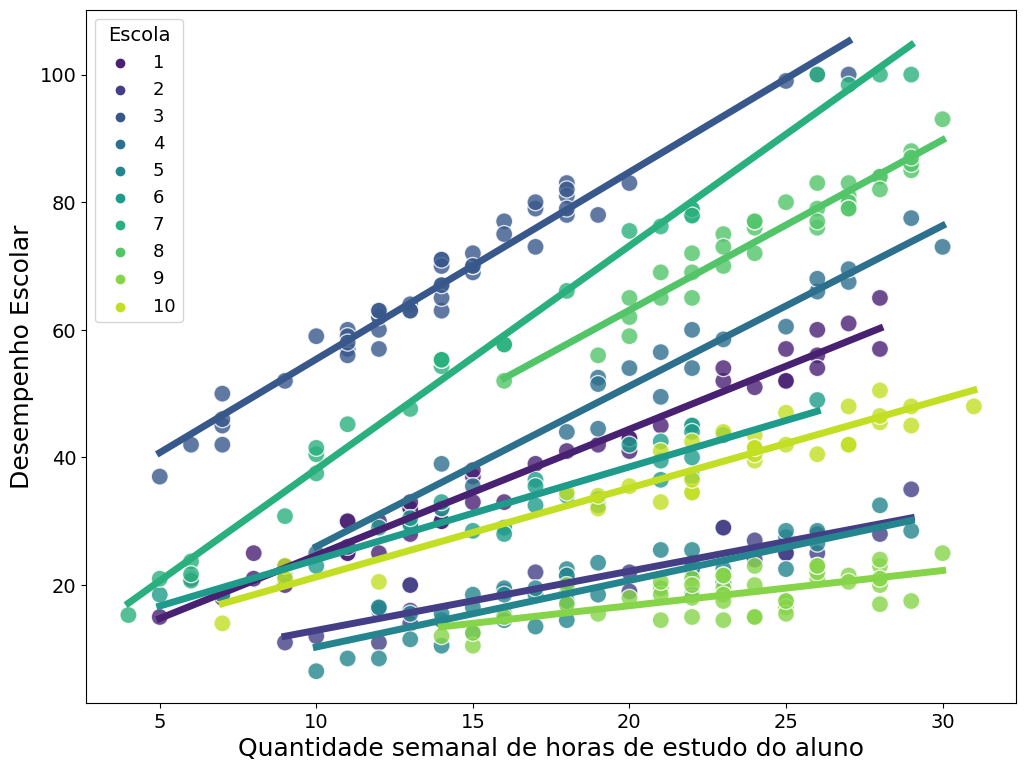

In [18]:
# In[1.12]: Gráfico de desempenho escolar em função da variável 'horas'
# Variação entre estudantes de uma mesma escola e entre escolas diferentes
# Visualização do contexto!
# NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!

palette = sns.color_palette('viridis',
                            len(df_aluno_escola['escola'].unique()))

plt.figure(figsize=(12,9))
sns.scatterplot(data=df_aluno_escola, x='horas', y='desempenho', hue='escola',
                palette=palette, s=150, alpha=0.8, edgecolor='w')

for escola in df_aluno_escola['escola'].cat.categories:
    subset = df_aluno_escola[df_aluno_escola['escola'] == escola]
    sns.regplot(data=subset, x='horas', y='desempenho', scatter=False, ci=False,
                line_kws={"color": palette[df_aluno_escola['escola'].cat.categories.get_loc(escola)], 'linewidth': 5})

plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=18)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Escola', title_fontsize='14', fontsize='13', loc='upper left')
plt.show()

In [19]:
# In[1.13]:
##############################################################################
#                        ESTIMAÇÃO DO MODELO NULO HLM2                       #
##############################################################################

# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')

modelo_nulo_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ 1', # Efeito fixo
                                           groups='escola',
                                           re_formula='1', # Efeito aleatório (random effects)
                                           data=df_aluno_escola).fit()

# Parâmetros do 'modelo_nulo_hlm2'
print(modelo_nulo_hlm2.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          



$desempenho_{ij} = \gamma_{00} + v_{0j} + \epsilon_{ij}$ (equação represetada no modelonulo acima)

Modelo nulo é OLS (variância dos termos de intercepto e inclinação próximas a zero)

Interpretação do output: 
- Scale: variância do $\epsilon_{ij}$
- Intercept: componente de efeito fixo ($\gamma_{00}$)
- escola Var: variância do $v_{0j}$
- ICC (*interclass correlation*): percentual de variância devido ao efeito 'escola' em relação ao total
$\frac{escola Var}{escola Var + Scale}$

In [27]:
# Intraclass correlation do modelo nulo (ICC):
    
icc_nulo = 414.067 / (414.067 + 142.9242)
icc_nulo

0.7433995366533618

74% dos efeitos devido à escola e não ao aluno

In [20]:
# In[1.14]: Análise da significância estatística dos efeitos aleatórios de
#intercepto

teste = float(modelo_nulo_hlm2.cov_re.iloc[0, 0]) /\
    float(pd.DataFrame(modelo_nulo_hlm2.summary().tables[1]).iloc[1, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

Estatística z para a Significância dos Efeitos Aleatórios: 24.802
P-valor: 0.000
Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.


24.802 > 2 portanto P-valor < 0.005

In [21]:
# In[1.15]:
##############################################################################
#                   COMPARAÇÃO DO HLM2 NULO COM UM OLS NULO                  #
##############################################################################

# Estimação de um modelo OLS nulo

modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df_aluno_escola).fit()

# Parâmetros do 'modelo_ols_nulo'
print(modelo_ols_nulo.summary())

                            OLS Regression Results                            
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                qua, 02 out 2024   Prob (F-statistic):                nan
Time:                        20:27:48   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5542      1.228     33.852      0.0

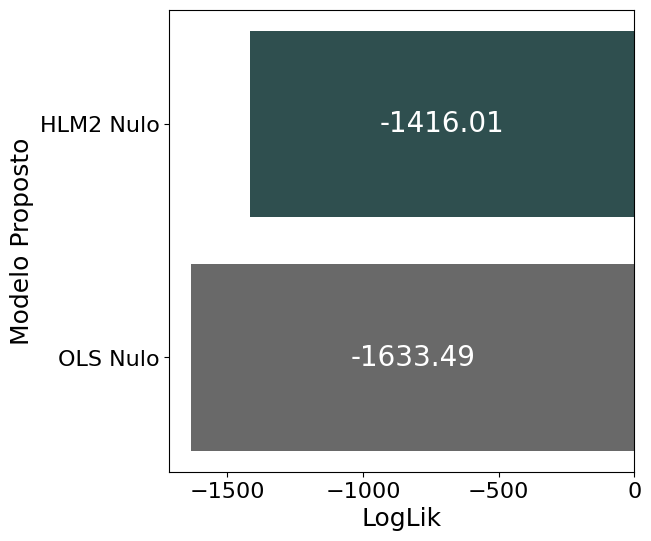

In [24]:
# In[1.16]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf]})

fig, ax = plt.subplots(figsize=(6,6))

c = ['dimgray','darkslategray']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=20)
ax.set_ylabel("Modelo Proposto", fontsize=18)
ax.set_xlabel("LogLik", fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
plt.show()

É aqui que definimos que vamos ficar com a modelagem multinível (modelo nulo) e não com o modelo OLS

In [25]:
# In[1.17]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o
#'modelo_ols_nulo'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [26]:
# In[1.18]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_ols_nulo' e 'modelo_nulo_hlm2'

lrtest([modelo_ols_nulo, modelo_nulo_hlm2])

Likelihood Ratio Test:
-2.(LL0-LLm): 434.96
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


In [29]:
# LR Test Manual
-2*(-1633.49 - (-1416.01))

434.96000000000004

In [ ]:
# In[1.19]:
##############################################################################
#     ESTIMAÇÃO DO MODELO COM INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS HLM2      #
##############################################################################

# Estimação do modelo com interceptos e inclinações aleatórios

modelo_intercept_inclin_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas',
                                                       groups='escola',
                                                       re_formula='horas',
                                                       data=df_aluno_escola).fit()

# Parâmetros do 'modelo_intercept_inclin_hlm2'
modelo_intercept_inclin_hlm2.summary()

# In[1.20]: Análise da significância estatística dos efeitos aleatórios de
#intercepto

teste = float(modelo_intercept_inclin_hlm2.cov_re.iloc[0, 0]) /\
    float(pd.DataFrame(modelo_intercept_inclin_hlm2.summary().tables[1]).iloc[2, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

# In[1.21]: Análise da significância estatística dos efeitos aleatórios de
#inclinação

teste = float(modelo_intercept_inclin_hlm2.cov_re.iloc[1, 1]) /\
    float(pd.DataFrame(modelo_intercept_inclin_hlm2.summary().tables[1]).iloc[4, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

# In[1.22]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo',
                                 'HLM2 com Int. e Incl. Aleat.'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_inclin_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[1.23]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o
#'modelo_intercept_inclin_hlm2'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 2) # 2 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[1.24]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_nulo_hlm2' e 'modelo_intercept_inclin_hlm2'

lrtest([modelo_nulo_hlm2, modelo_intercept_inclin_hlm2])

# In[1.25]:
##############################################################################
#  ESTIMAÇÃO DO MODELO FINAL COM INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS HLM2   #
##############################################################################

# Estimação do modelo final com interceptos e inclinações aleatórios

modelo_final_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas + texp +\
                                            horas:texp',
                                            groups='escola',
                                            re_formula='horas',
                                            data=df_aluno_escola).fit()

# Parâmetros do modelo 'modelo_final_hlm2'
modelo_final_hlm2.summary()

# In[1.26]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo',
                                 'HLM2 com Int. e Incl. Aleat.',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_inclin_hlm2.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[1.27]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_intercept_inclin_hlm2' e 'modelo_final_hlm2'

lrtest([modelo_intercept_inclin_hlm2, modelo_final_hlm2])

# In[1.28]: Visualização dos interceptos e inclinações aleatórios por escola,
#para o 'modelo_final_hlm2'

pd.DataFrame(modelo_final_hlm2.random_effects)

# In[1.29]: Melhor visualização dos interceptos e inclinações aleatórios por
#escola, para o 'modelo_final_hlm2'

efeitos_aleatorios = pd.DataFrame(modelo_final_hlm2.random_effects).T
efeitos_aleatorios = efeitos_aleatorios.rename(columns = {'escola':'v0j'})
efeitos_aleatorios = efeitos_aleatorios.rename(columns = {'horas':'v1j'})
efeitos_aleatorios = efeitos_aleatorios.reset_index().rename(columns={'index': 'escola'})
efeitos_aleatorios

# In[1.30]: Gráfico para visualização do comportamento dos valores de v0j,
#ou seja, dos interceptos aleatórios por escola

# Para a construção deste gráfico, é necessário, momentaneamente, transformar a
#variável 'escola' para o formato 'int'

df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('int')

colors = ['springgreen' if x>0 else 'red' for x in efeitos_aleatorios['v0j']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15,10))
plt.barh(efeitos_aleatorios['escola'], efeitos_aleatorios['v0j'], color=colors)

label_point(x = efeitos_aleatorios['v0j'],
            y = efeitos_aleatorios['escola'],
            val = efeitos_aleatorios['v0j'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=18)
plt.xlabel(r'$\nu_{0j}$', fontsize=18)
plt.tick_params(axis='x', fontsize=16)
plt.tick_params(axis='y', fontsize=16)
plt.yticks(np.arange(0, 11, 1))
plt.show()

# In[1.31]: Gráfico para visualização do comportamento dos valores de v1j,
#ou seja, das inclinações aleatórias por escola

colors = ['springgreen' if x>0 else 'red' for x in efeitos_aleatorios['v1j']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15,10))
plt.barh(efeitos_aleatorios['escola'], efeitos_aleatorios['v1j'], color=colors)

label_point(x = efeitos_aleatorios['v1j'],
            y = efeitos_aleatorios['escola'],
            val = efeitos_aleatorios['v1j'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=18)
plt.xlabel(r'$\nu_{1j}$', fontsize=18)
plt.tick_params(axis='x', fontsize=16)
plt.tick_params(axis='y', fontsize=16)
plt.yticks(np.arange(0, 11, 1))
plt.show()

# In[1.32]: Tornando novamente a variável 'escola' categórica

df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('category')

# In[1.33]: Visualização dos fitted values do 'modelo_final_hlm2', por
#estudante e por escola

df_aluno_escola['fitted.fixed'] = pd.DataFrame(modelo_final_hlm2.predict())
df_aluno_escola['fitted.completo'] = modelo_final_hlm2.fittedvalues
df_aluno_escola['eij'] = modelo_final_hlm2.resid
df_aluno_escola

# In[1.34]: Elaboração de previsões para o 'modelo_final_hlm2':
# Exemplo: Quais os valores previstos de desempenho escolar, para dado
#aluno que estuda na escola "1", sabendo-se que estuda 11 horas por semana e
#que a escola oferece tempo médio de experiência de seus professores igual a
#3,6 anos?

# O resultado obtido por meio da função 'predict' só considera efeitos fixos.
# Criação do objeto 'resultado_fixo' apenas com o efeito fixo

resultado_fixo = modelo_final_hlm2.predict(pd.DataFrame({'horas':[11],
                                                         'texp':[3.6],
                                                         'escola':['1']}))
resultado_fixo

# A função 'predict' não considera os efeitos aleatórios de intercepto ou de
#inclinação por 'escola'. Neste sentido, precisamos adicioná-los a partir dos
#parâmetros do 'modelo_final_hlm2', conforme segue.

# In[1.35]: Predição completa para o enunciado anterior, com efeitos fixos e
#aleatórios para a escola 1

resultado_completo = resultado_fixo + efeitos_aleatorios['v0j'][0] +\
    efeitos_aleatorios['v1j'][0]*11

resultado_completo

# In[1.36]: Gráfico com valores previstos do desempenho escolar em função da
#variável 'horas' para o 'modelo_final_hlm2'

plt.figure(figsize=(15, 10))

escolas = df_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

for escola in escolas:
    plt.plot(df_aluno_escola[df_aluno_escola['escola'] == escola].horas,
             df_aluno_escola[df_aluno_escola['escola'] == escola]['fitted.completo'],
             color=colors[escola-1])
    plt.scatter(df_aluno_escola[df_aluno_escola['escola'] == escola].horas,
                df_aluno_escola[df_aluno_escola['escola'] == escola]['fitted.completo'],
                color=colors[escola-1])

plt.ylabel('Desempenho Escolar (Fitted Values)', fontsize=18)
plt.xlabel('Quantidade Semanal de Horas de Estudo do Aluno', fontsize=18)

# Criação da legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                              markersize=10, label=f'Escola {escola}')
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14, title_fontsize=16)
plt.show()

# In[1.37]:
##############################################################################
#                     COMPARAÇÃO COM UM MODELO OLS                           #
##############################################################################

# Estimação de um modelo OLS para fins de comparação

modelo_ols = sm.OLS.from_formula('desempenho ~ horas + texp', df_aluno_escola).fit()

# Parâmetros do modelo
modelo_ols.summary()

# In[1.38]: Gráfico para comparação visual dos logLiks dos modelos HLM2 Final
#e OLS

df_llf = pd.DataFrame({'modelo': ['OLS', 'HLM2 Modelo Final'],
                       'loglik': [modelo_ols.llf, modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15, 10))

colors = ['navy', 'deeppink']

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color=colors)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.show()

# In[1.39]: Gráfico para a comparação dos fitted values dos modelos HLM2 Final
#e OLS

plt.figure(figsize=(15,10))
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['desempenho'],
            ci=None,
            line_kws={'color':'black', 'linewidth':2, 'linestyle':'--'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=modelo_ols.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'navy', 's':50, 'alpha':0.5},
            line_kws={'color':'navy', 'linewidth':5,
                      'label':'OLS'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['fitted.completo'],
            ci=None, marker='s', order=5,
            scatter_kws={'color':'deeppink', 's':50, 'alpha':0.5},
            line_kws={'color':'deeppink', 'linewidth':5,
                      'label':'HLM2'})
plt.xlabel('Desempenho', fontsize=18)
plt.ylabel('Fitted Values', fontsize=18)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)
plt.show()

# In[1.40]:
##############################################################################
#                COMPARAÇÃO COM UM MODELO OLS COM DUMMIES                    #
##############################################################################

# Dummizando a variável 'escola'. O código abaixo automaticamente fará: 
# a)o estabelecimento de dummies que representarão cada uma das escolas do dataset;
# b)removerá a variável original a partir da qual houve a dummização;
# c)estabelecerá como categoria de referência a primeira categoria, ou seja,
# a escola '1' por meio do argumento 'drop_first=True'.

df_aluno_escola_dummies = pd.get_dummies(df_aluno_escola, columns=['escola'],
                                         dtype=int,
                                         drop_first=True)

df_aluno_escola_dummies.head(10)

# In[1.41]: Estimação do modelo de regressão múltipla com n-1 dummies

# Definição da fórmula utilizada no modelo

lista_colunas = list(df_aluno_escola_dummies.drop(columns=['estudante','desempenho',
                                                           'fitted.fixed',
                                                           'fitted.completo',
                                                           'eij']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "desempenho ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

# In[1.42]: Estimação do modelo com n-1 dummies propriamente dito

modelo_ols_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_aluno_escola_dummies).fit()

# Parâmetros do 'modelo_ols_dummies'
modelo_ols_dummies.summary()

# In[1.43]: Procedimento Stepwise para o 'modelo_ols_dummies'

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

# Estimação do modelo por meio do procedimento Stepwise

modelo_ols_dummies_step = stepwise(modelo_ols_dummies, pvalue_limit=0.05)

# In[1.44]: Gráfico para comparação visual dos logLiks dos modelos HLM2 Final,
#OLS e OLS com Dummies e Stepwise

df_llf = pd.DataFrame({'modelo':['OLS',
                                 'OLS com Dummies e Step.',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols.llf,
                                modelo_ols_dummies_step.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['navy','dodgerblue','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[1.45]: Comparação entre os parâmetros dos modelos (atente-se para a
#quantidade de parâmetros estimados em cada um deles!)

summary_col([modelo_ols_dummies_step, modelo_final_hlm2],
            model_names=["OLS com Dummies","HLM2 Final"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

# In[1.46]: Gráfico para a comparação entre os fitted values dos modelos
#HLM2 Final, OLS e OLS com Dummies e Procedimento Stepwise

plt.figure(figsize=(15,10))
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['desempenho'],
            ci=None,
            line_kws={'color':'black', 'linewidth':2, 'linestyle':'--'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=modelo_ols.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'navy', 's':40, 'alpha':0.5},
            line_kws={'color':'navy', 'linewidth':5,
                      'label':'OLS'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=modelo_ols_dummies_step.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'dodgerblue', 's':40, 'alpha':0.5},
            line_kws={'color':'dodgerblue', 'linewidth':5,
                      'label':'OLS com Dummies'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['fitted.completo'],
            ci=None, marker='s', order=5,
            scatter_kws={'color':'deeppink', 's':40, 'alpha':0.5},
            line_kws={'color':'deeppink', 'linewidth':5,
                      'label':'HLM2'})
plt.xlabel('Desempenho', fontsize=18)
plt.ylabel('Fitted Values', fontsize=18)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)
plt.show

# In[1.47]: Gráfico para comparação visual dos logLiks de todos os modelos
#estimados neste exemplo

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo','OLS',
                                 'OLS com Dummies e Step.',
                                 'HLM2 com Int. e Incl. Aleat.',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_ols.llf,
                                modelo_ols_dummies_step.llf,
                                modelo_intercept_inclin_hlm2.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','navy','dodgerblue','indigo','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()


# In[HLM3 COM MEDIDAS REPETIDAS]:
##############################################################################
##############################################################################
#                ESTIMAÇÃO DE MODELOS HIERÁRQUICOS LINEARES                  #
#                   DE TRÊS NÍVEIS COM MEDIDAS REPETIDAS                     #
##############################################################################
##############################################################################

##############################################################################
#     DESCRIÇÃO E EXPLORAÇÃO DO DATASET 'desempenho_tempo_aluno_escola'      #
##############################################################################

# Carregamento da base de dados 'desempenho_tempo_aluno_escola'
df_tempo_aluno_escola = pd.read_csv('desempenho_tempo_aluno_escola.csv',
                                    delimiter=',')

# Visualização da base de dados 'desempenho_tempo_aluno_escola'
df_tempo_aluno_escola

# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('category')
df_tempo_aluno_escola['escola'] = df_tempo_aluno_escola['escola'].astype('category')

# Características das variáveis do dataset
df_tempo_aluno_escola.info()

# Estatísticas univariadas
df_tempo_aluno_escola.describe()

# In[2.1]: Estudo sobre o balanceamento dos dados em relação à quantidade de
#alunos por período analisado

df_tempo_aluno_escola.groupby('mes')['estudante'].count().reset_index()

# In[2.2]: Estudo sobre o desbalanceamento da quantidade de alunos aninhados
#em escolas

(df_tempo_aluno_escola.groupby('escola')['estudante'].count()/4).reset_index()

# In[2.3]: Desempenho escolar médio dos estudantes em cada período (mês)

df_tempo_aluno_escola.groupby('mes')['desempenho'].mean().reset_index()

# In[2.4]: Gráfico com a evolução do desempenho escolar médio dos estudantes
#em cada período (ajuste linear)

plt.figure(figsize=(15,10))
sns.regplot(x=df_tempo_aluno_escola['mes'], y=df_tempo_aluno_escola['desempenho'],
            ci=None, marker='o',
            scatter_kws={'color':'gold', 's':170, 'alpha':0.2},
            line_kws={'color':'darkorchid', 'linewidth':10})
plt.xlabel('Mês', fontsize=18)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.tick_params(axis='y', fontsize=16)
plt.tick_params(axis='x', fontsize=16)
plt.xticks(np.arange(1, 5, 1))
plt.show

# In[2.5]: Gráfico com a evolução temporal do desempenho escolar dos 50 primeiros
#estudantes da amostra (50 estudantes em razão da visualização no gráfico)

# Seleção dos 50 primeiros estudantes
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('int')
df_amostra = df_tempo_aluno_escola[df_tempo_aluno_escola['estudante'] <= 50]
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('category')

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.lineplot(x='mes', y='desempenho', data=df_amostra,
             hue='estudante', marker="o", palette='viridis', markersize=10)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.xlabel('Mês', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', fontsize=16)
plt.tick_params(axis='x', fontsize=16)
plt.xticks(np.arange(1, 5, 1))
plt.show()

# In[2.6]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma

plt.figure(figsize=(15,10))
sns.histplot(data=df_tempo_aluno_escola.desempenho, kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho', fontsize=18)
plt.ylabel('Contagem', fontsize=18)
plt.tick_params(axis='y', fontsize=16)
plt.tick_params(axis='x', fontsize=16)
plt.show()

# In[2.7]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho') por escola

escolas = df_tempo_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

plt.figure(figsize=(15, 10))
g = sns.pairplot(df_tempo_aluno_escola[['escola', 'desempenho']], hue='escola',
                 height=8,
                 aspect=1.5, palette=colors)
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
g.tick_params(axis='both', which='major', labelsize=15)

# Gera a legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color,
                              markersize=10, label=escola)
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14,
           title_fontsize=18)

# Adiciona os rótulos diretamente na figura
plt.gcf().text(0.5, -0.01, 'Desempenho Escolar', ha='center', fontsize=18)
plt.gcf().text(-0.01, 0.5, 'Frequência', va='center', rotation='vertical',
               fontsize=18)
plt.show()

# In[2.8]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma e por escola separadamente
#(função 'GridSpec' do pacote 'matplotlib.gridspec')

escolas = df_tempo_aluno_escola['escola'].unique()

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

for i, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[i])

    # Subset dos dados por escola
    df_escola = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]

    # Densidade dos dados
    densidade = gaussian_kde(df_escola['desempenho'])
    x_vals = np.linspace(min(df_escola['desempenho']),
                         max(df_escola['desempenho']), len(df_escola))
    y_vals = densidade(x_vals)

    # Plotagem da density area
    ax.fill_between(x_vals, y_vals,
                    color=sns.color_palette('viridis',
                                            as_cmap=True)(i/len(escolas)),
                    alpha=0.3)
    
    # Adiciona o histograma
    sns.histplot(df_escola['desempenho'], ax=ax, stat="density", color="black",
                 edgecolor="black", fill=True, 
                 bins=15, alpha=0.1)
    ax.set_title(f'Escola {escola}', fontsize=15)
    ax.set_ylabel('Densidade')
    ax.set_xlabel('Desempenho')

plt.tight_layout()
plt.show()

# In[2.9]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), por escola separadamente
# Animação no ambiente Plots

escolas = df_tempo_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

while True:
    # Loop para cada escola
    for escola in escolas:
        # Filtro dos dados para determinada escola
        data = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]

        # Criação do FacetGrid com a cor específica
        g = sns.FacetGrid(data, hue='escola', palette=[cor_escola[escola]])
        g.map(sns.histplot, 'desempenho', kde=True)
        g.ax.set_title(f"Desempenho escolar - Escola {escola}", fontsize=10)
        g.ax.set_xlabel('Desempenho Escolar', fontsize=8)
        g.ax.set_ylabel('Contagem', fontsize=8)
        g.ax.tick_params(axis='x', labelsize=7)
        g.ax.tick_params(axis='y', labelsize=7)

        # Ajustar os rótulos dos eixos
        plt.xticks(np.arange(0, 101, 20))
        plt.yticks(np.arange(0, 101, 20))
        plt.tight_layout()
        
        # Plotagem da figura
        plt.show()

        # Intervalo de tempo entre os gráficos
        time.sleep(1)

# In[2.10]: Gráfico da evolução temporal do desempenho médio por escola
#(ajustes lineares)
# NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!

palette = sns.color_palette('viridis',
                            len(df_tempo_aluno_escola['escola'].unique()))

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_tempo_aluno_escola, x='mes', y='desempenho', hue='escola',
                palette=palette, s=200, alpha=0.8, edgecolor='w')

for escola in df_tempo_aluno_escola['escola'].cat.categories:
    subset = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]
    sns.regplot(data=subset, x='mes', y='desempenho', scatter=False, ci=False,
                line_kws={"color": palette[df_tempo_aluno_escola['escola'].\
                                           cat.categories.get_loc(escola)],
                          'linewidth': 5})

plt.xlabel('Mês', fontsize=18)
plt.ylabel('Desempenho Escolar', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Escola', title_fontsize='14', fontsize='13', loc='best')
plt.show()

# In[2.11]: Gráfico de desempenho x mês por escola separadamente
# Animação no ambiente Plots

escolas = df_tempo_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

while True:
    # Loop para cada escola
    for escola in escolas:
        # Filtro dos dados para determinada escola
        data = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]

        # Criação da figura e dos eixos separadamente
        fig, ax = plt.subplots()
        
        # Criação do lmplot com a cor específica
        sns.regplot(x='mes', y='desempenho', data=data, color=cor_escola[escola],
                    ax=ax, ci=False)
        plt.title(f"Desempenho escolar - Escola {escola}", fontsize=12)
        plt.xlabel("Mês", fontsize=10)
        plt.ylabel("Desempenho Escolar", fontsize=10)
        plt.tick_params(axis='x', labelsize=8)
        plt.tick_params(axis='y', labelsize=8)
        plt.yticks(np.arange(0, 101, 20))
        plt.xticks(np.arange(1, 5, 1))
        plt.tight_layout()
        ax.legend([f'Escola {escola}'], loc='upper center',
                  bbox_to_anchor=(.5, -0.15), ncol=1)

        # Plotagem da figura
        plt.show()

        # Intervalo de tempo entre os gráficos
        time.sleep(1)

# In[2.12]:
##############################################################################
#                        ESTIMAÇÃO DO MODELO NULO HLM3                       #
##############################################################################

# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')

modelo_nulo_hlm3 = sm.MixedLM.from_formula(formula='desempenho ~ 1',
                                           groups='escola',
                                           re_formula='1',
                                           vc_formula={'estudante': '0 + C(estudante)'},
                                           data=df_tempo_aluno_escola).fit()

# Parâmetros do 'modelo_nulo_hlm3'
modelo_nulo_hlm3.summary()

# In[2.13]: A partir deste momento, iremos estimar os modelos multinível HLM3
#com medidas repetidas por meio da função 'Lmer' do pacote 'pymer4.models',
#já que esta função permite que sejam considerados efeitos aleatórios de
#inclinação para os níveis 2 e 3 simultaneamente, ao contrário da função
#'MixedLM' do pacote 'statsmodels', que permite a inclusão de tais efeitos em
#apenas um dos níveis contextuais

# Transformação das variáveis 'estudante' e 'escola' para 'int64', a fim de que
#seja possível estimar os modelos multinível por meio da função 'Lmer' do
#pacote 'pymer4.models'

df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('int64')
df_tempo_aluno_escola['escola'] = df_tempo_aluno_escola['escola'].astype('int64')

# Estimação do modelo nulo (função 'Lmer' do pacote 'pymer4.models')

modelo_nulo_hlm3 = Lmer(formula='desempenho ~ 1 + (1|escola) + (1|estudante)',
                        data=df_tempo_aluno_escola)

# Parâmetros do 'modelo_nulo_hlm3'
modelo_nulo_hlm3.fit()

# In[2.14]:
##############################################################################
#                   COMPARAÇÃO DO HLM3 NULO COM UM OLS NULO                  #
##############################################################################

# Estimação de um modelo OLS nulo

modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df_tempo_aluno_escola).fit()

# Parâmetros do 'modelo_ols_nulo'
modelo_ols_nulo.summary()

# In[2.15]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM3 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[2.16]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm3' e o
#'modelo_ols_nulo'

# Definição da função 'lrtest'
# ATENÇÃO: o valor de log-likelihood de modelos estimados por meio da função
#'Lmer' do pacote 'pymer4.models' é obtido pelo argumento '.logLike'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelos[1].logLike
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].logLike
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 2) # 2 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[2.17]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_ols_nulo' e 'modelo_nulo_hlm3'

lrtest([modelo_ols_nulo, modelo_nulo_hlm3])

# In[2.18]:
##############################################################################
#              ESTIMAÇÃO DO MODELO HLM3 COM TENDÊNCIA LINEAR E               #
#                   INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS                     #
##############################################################################

# Estimação do modelo com tendência linear e interceptos e inclinações aleatórios

modelo_intercept_inclin_hlm3 = Lmer('desempenho ~ mes + (mes|escola) + (mes|estudante)',
                                    data = df_tempo_aluno_escola)

# Parâmetros do 'modelo_intercept_inclin_hlm3'
modelo_intercept_inclin_hlm3.fit()

# In[2.19]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM3 Nulo',
                                 'HLM3 com Int. e Incl. Aleat.'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm3.logLike,
                                modelo_intercept_inclin_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[2.20]: Teste de razão de verossimilhança para comparar as estimações do
#modelo HLM3 nulo e do presente modelo

# Definição da função 'lrtest2'
# ATENÇÃO: o valor de log-likelihood de modelos estimados por meio da função
#'Lmer' do pacote 'pymer4.models' é obtido pelo argumento '.logLike'

def lrtest2(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.logLike
    llk_2 = modelos[1].logLike
    
    if len(modelos)>1:
        llk_1 = modelo_1.logLike
        llk_2 = modelos[1].logLike
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 3) # 3 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[2.21]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_nulo_hlm3' e 'modelo_intercept_inclin_hlm3'

lrtest2([modelo_nulo_hlm3, modelo_intercept_inclin_hlm3])

# In[2.22]:
##############################################################################
#              ESTIMAÇÃO DO MODELO HLM3 COM TENDÊNCIA LINEAR,                #
#                   INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS                     #
#          E AS VARIÁVEIS 'ativ' DE NÍVEL 2 E 'text' DE NÍVEL 3              #
##############################################################################

# Dummização da variável preditora qualitativa 'ativ', a fim de que seja possível
#estabelecer, adiante, as funções para a definição dos efeitos aleatórios dos
#níveis contextuais.

df_tempo_aluno_escola = pd.get_dummies(df_tempo_aluno_escola, columns=['ativ'],
                                       dtype=int,
                                       drop_first=True)

# Estimação do modelo com tendência linear, interceptos e inclinações aleatórios
#e as variáveis 'ativ' de nível 2 e 'texp' de nível 3

modelo_completo_final_hlm3 = Lmer('desempenho ~ mes + ativ_sim + texp +\
                                  ativ_sim:mes + texp:mes +\
                                      (mes|escola) + (mes|estudante)',
                                      data = df_tempo_aluno_escola)

# Parâmetros do 'modelo_completo_final_hlm3'
modelo_completo_final_hlm3.fit()

# In[2.23]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM3 Nulo',
                                 'HLM3 com Int. e Incl. Aleat.',
                                 'HLM3 Completo Níveis 2 e 3'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm3.logLike,
                                modelo_intercept_inclin_hlm3.logLike,
                                modelo_completo_final_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo','purple']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[2.24]: Teste de razão de verossimilhança para comparar as estimações do
#presente modelo e do modelo anterior

# Definição da função 'lrtest3'

def lrtest3(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.logLike
    llk_2 = modelos[1].logLike
    
    if len(modelos)>1:
        llk_1 = modelo_1.logLike
        llk_2 = modelos[1].logLike
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 4) # 4 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[2.25]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_intercept_inclin_hlm3' e 'modelo_completo_final_hlm3'

lrtest3([modelo_intercept_inclin_hlm3, modelo_completo_final_hlm3])

# In[2.26]: Visualização dos interceptos e inclinações aleatórios por estudante

# Valores de v0jk e v1jk para o 'modelo_completo_final_hlm3' (efeitos aleatórios
#de intercepto e de inclinação no nível estudante, respectivamente)

aleat_estudante = pd.DataFrame(modelo_completo_final_hlm3.ranef[0]).dropna()
aleat_estudante = aleat_estudante.rename(columns={'(Intercept)':'v0jk','mes':'v1jk'})
aleat_estudante = aleat_estudante.reset_index().rename(columns={'index': 'estudante'})
aleat_estudante

# In[2.27]: Visualização dos interceptos e inclinações aleatórios por escola

# Valores de t00k e t10k para o 'modelo_completo_final_hlm3' (efeitos aleatórios
#de intercepto e de inclinação no nível escola, respectivamente)

aleat_escola = pd.DataFrame(modelo_completo_final_hlm3.ranef[1]).dropna()
aleat_escola = aleat_escola.rename(columns={'(Intercept)':'t00k','mes':'t10k'})
aleat_escola = aleat_escola.reset_index().rename(columns={'index': 'escola'})
aleat_escola

# In[2.28]: Gráfico para visualização do comportamento dos valores de t00k,
#ou seja, dos interceptos aleatórios por escola

colors = ['springgreen' if x > 0 else 'red' for x in aleat_escola['t00k']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'], 4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15, 10))
plt.barh(aleat_escola['escola'], aleat_escola['t00k'], color=colors)

label_point(x=aleat_escola['t00k'],
            y=aleat_escola['escola'],
            val=aleat_escola['t00k'],
            ax=plt.gca()) 

plt.ylabel('Escola', fontsize=18)
plt.xlabel('$\\tau_{00k}$', fontsize=18)
plt.tick_params(axis='x', fontsize=16)
plt.tick_params(axis='y', fontsize=16)
plt.yticks(np.arange(0, 16, 1))
plt.show()

# In[2.29]: Gráfico para visualização do comportamento dos valores de t10k,
#ou seja, das inclinações aleatórias por escola

colors = ['springgreen' if x>0 else 'red' for x in aleat_escola['t10k']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15,10))
plt.barh(aleat_escola['escola'], aleat_escola['t10k'], color=colors)

label_point(x = aleat_escola['t10k'],
            y = aleat_escola['escola'],
            val = aleat_escola['t10k'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=18)
plt.xlabel('$\\tau_{10k}$', fontsize=18)
plt.tick_params(axis='x', fontsize=16)
plt.tick_params(axis='y', fontsize=16)
plt.yticks(np.arange(0, 16, 1))
plt.show()

# In[2.30]: Definição da função 'predict_fixed' para o estabelecimento dos
#valores presentes no componente de efeitos fixos

def predict_fixed(df:pd.DataFrame, model:Lmer):
    
    coefs = list(model.coefs.index)
    intercept = model.coefs['Estimate'][coefs[0]]
    equation = [str(intercept)]
    
    for index, item in enumerate(coefs[1:]):
       
        if item.find(":") != -1:
            nested = item.split(":")
            equation.append(str(nested[0]) + " * " + str(nested[1]) + " * " + str(model.coefs['Estimate'][item]))
        
        else:
            equation.append(item + " * " + str(model.coefs['Estimate'][item]))
    
    final_equation = " + ".join(equation)
    
    final_equation = "fitted_fixed =" + final_equation
    
    return df.eval(final_equation)

# In[2.31]: Dataframe com os valores presentes no componente de efeitos fixos
#(variável 'fitted_fixed')

df_tempo_aluno_escola = predict_fixed(df_tempo_aluno_escola,
                                      modelo_completo_final_hlm3)
df_tempo_aluno_escola

# In[2.32]: Modo direto para a definição dos valores de 'fitted_completo'

df_tempo_aluno_escola['fitted_completo'] = pd.DataFrame(modelo_completo_final_hlm3.fits)

# In[2.33]: Definição dos valores de 'etjk'

df_tempo_aluno_escola['etjk'] = modelo_completo_final_hlm3.residuals

# In[2.34]: Visualização do dataframe 'df_effects' com os valores de
#'fitted_fixed', 'fitted_completo' e 'etjk'

df_effects = df_tempo_aluno_escola[['escola','estudante','mes','desempenho',
                                    'fitted_fixed','fitted_completo','etjk']]

df_effects

# In[2.35]: Elaboração de previsões para o 'modelo_completo_final_hlm3':

# Exemplo: Quais os valores previstos de desempenho escolar no primeiro mês
#('mes' = 1) para o estudante '1' da escola '1', sabendo-se que esta escola
#oferece tempo médio de experiência de seus professores igual a 2 anos?

# Predict para ativ_sim = 0

pred_0 = modelo_completo_final_hlm3.predict(pd.DataFrame({'escola':[1],
                                                          'estudante':[1],
                                                          'mes':[1],
                                                          'ativ_sim':[0],
                                                          'texp':[2]}),
                                            skip_data_checks=True)
pred_0

# Predict para ativ_sim = 1
#(caso o estudante passasse a realizar atividades complementares de estudo)

pred_1 = modelo_completo_final_hlm3.predict(pd.DataFrame({'escola':[1],
                                                          'estudante':[1],
                                                          'mes':[1],
                                                          'ativ_sim':[1],
                                                          'texp':[2]}),
                                            skip_data_checks=True)
pred_1

# In[2.36]: Gráfico com os valores previstos do desempenho escolar ao longo do
#tempo para os 47 primeiros estudantes da amostra (47 estudantes que estão na
#escola '1')

df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('int')
df = df_tempo_aluno_escola[df_tempo_aluno_escola['estudante'] <= 47]
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('category')

plt.figure(figsize=(15, 10))
sns.set(style='whitegrid')
g = sns.lmplot(x='mes', y='fitted_completo', data=df, hue='estudante',
           ci=False, height=7, palette='viridis')
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
plt.ylabel('Desempenho Escolar', fontsize=14)
plt.xlabel('Mês', fontsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.xticks(np.arange(1, 5, 1))
legend = plt.legend(title='Estudante', fontsize=12, title_fontsize=14, ncol=2,
                    loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)
legend.get_title().set_position((10, 0))
plt.show()

# In[2.37]:
##############################################################################
#          FINALIZANDO... COMPARAÇÃO COM UM MODELO OLS COM DUMMIES           #
##############################################################################

# Procedimento para criação de n-1 dummies para as escolas

base_para_dummies = df_tempo_aluno_escola[['estudante','escola','desempenho',
                                           'mes','texp','ativ_sim']]

base_dummizada = pd.get_dummies(base_para_dummies, columns=['escola'],
                                dtype=int,
                                drop_first=True)
base_dummizada

# In[2.38]: Estimação de um modelo OLS com as mesmas variáveis do modelo HLM3

# Criação das variáveis multiplicativas e definição da expressão a ser
#utilizada no modelo

base_dummizada['ativ_mes'] = base_dummizada['ativ_sim'] * base_dummizada['mes']
base_dummizada['texp_mes'] = base_dummizada['texp'] * base_dummizada['mes']

lista_colunas = list(base_dummizada.drop(columns=['estudante',
                                                  'desempenho']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "desempenho ~ " + formula_dummies_modelo
formula_dummies_modelo

# In[2.39]: Estimação do 'modelo_ols_dummies'

modelo_ols_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                         base_dummizada).fit()

# Parâmetros do 'modelo_ols_dummies'
modelo_ols_dummies.summary()

# In[2.40]: Procedimento Stepwise para o 'modelo_ols_dummies'

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

# Estimação do modelo por meio do procedimento Stepwise

modelo_ols_dummies_step = stepwise(modelo_ols_dummies, pvalue_limit=0.05)

# In[2.41]: Gráfico para comparação visual dos logLiks dos modelos HLM3
#completo e OLS com dummies e procedimento Stepwise

df_llf = pd.DataFrame({'modelo':['OLS Final com Stepwise',
                                 'HLM3 Completo Níveis 2 e 3'],
                      'loglik':[modelo_ols_dummies_step.llf,
                                modelo_completo_final_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['salmon','purple']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

# In[2.42]: Gráfico para a comparação dos fitted values dos modelos HLM3
#completo e OLS com dummies e procedimento Stepwise

plt.figure(figsize=(15,10))
sns.regplot(x=df_tempo_aluno_escola['desempenho'],
            y=df_tempo_aluno_escola['desempenho'],
            ci=None,
            line_kws={'color':'black', 'linewidth':2, 'linestyle':'--'})
sns.regplot(x=df_tempo_aluno_escola['desempenho'],
            y=modelo_ols_dummies.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'salmon', 's':40, 'alpha':0.5},
            line_kws={'color':'salmon', 'linewidth':5,
                      'label':'OLS'})
sns.regplot(x=df_tempo_aluno_escola['desempenho'],
            y=df_tempo_aluno_escola['fitted_completo'],
            ci=None, marker='s', order=5,
            scatter_kws={'color':'purple', 's':40, 'alpha':0.5},
            line_kws={'color':'purple', 'linewidth':5,
                      'label':'HLM3'})
plt.xlabel('Desempenho', fontsize=18)
plt.ylabel('Fitted Values', fontsize=18)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)
plt.show

# ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ FIM ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ ☺ ♥ #